# Kernel Density Estimation for Wekas in the Marlborough Sounds

This notebook sets up a QGIS KDE plot of Weka observations, using field data kindly provided by Graeme Elliot & the Threats Science Team at the [Department of Conservation](https://www.doc.govt.nz/our-work/managing-threats/).  This is obviously way over the top for such a simple study, I'm just trying to get good systems in place for more complex modelling in future.

### Imports

In [1]:
#Python standard libraries
import platform
from pathlib import Path
import random
import shutil

#Conda packages
import pandas as pd
import geopandas as gpd
from qgis.core import QgsRasterLayer, QgsRasterPipe, QgsRasterResampler
from osgeo import gdal  #Does this still work on linux?
from qgis.core import QgsRasterLayer
gdal.UseExceptions()
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import contextily as ctx
from shapely.geometry import Point
from pyproj import Transformer
from ipyleaflet import Map, CircleMarker, Rectangle, basemaps
from PIL import Image
from IPython.display import display
from osgeo_utils import gdal2tiles
from IPython.display import Image as IPImage

# QGIS
from qgis.gui import *
from qgis.core import *
from qgis.utils import plugins
from qgis.core import QgsRasterBandStats

from qgis.analysis import QgsNativeAlgorithms 
from processing.algs.gdal.GdalAlgorithmProvider import GdalAlgorithmProvider
#from grassprovider.Grass7AlgorithmProvider import Grass7AlgorithmProvider
#from processing.algs.grass7.Grass7AlgorithmProvider import Grass7AlgorithmProvider
#from processing.algs.saga.SagaAlgorithmProvider import SagaAlgorithmProvider
from PyQt5.QtCore import *
from PyQt5.QtGui import QColor, QPainter
from PyQt5.QtWidgets import QApplication

Application path not initialized


### Filepaths

In [2]:
class Paths():
    '''An namespace for any the notebook's file paths'''
    if platform.system() =='Windows':
        PROJECT_ROOT = Path("F:/Documents/GIS/geoNotebooks")
        #PROJECT_ROOT = Path("C:/Users/ollyp/OneDrive/Desktop/geoNotebooks")
        QGIS_PREFIX = 'C:/Program Files/QGIS 3.38.2'
    else:
        PROJECT_ROOT = Path("/media/olly/Blue_SSD/Documents/GIS/geoNotebooks")
        QGIS_PREFIX = '/usr'
    
    WORKING = PROJECT_ROOT / 'Working'
    DATA = PROJECT_ROOT / 'Data'
    RESULTS = PROJECT_ROOT / 'Results'
    PROJECT_FILE = str(WORKING / 'weka_example_project.qgz')
    WEKA_POINTS = str(DATA / 'weka.csv')
    WEKA_GPKG = str(WORKING / 'weka.gpkg')
    MARL_GPKG_STR = 'marlborough-lidar-index-tiles-2020-2022'
    LIDAR_IDX_GPKG = str(DATA / f'lds-{MARL_GPKG_STR}-GPKG' / f'{MARL_GPKG_STR}.gpkg')
    LIDAR_TILES = str(DATA / 'lds-marlborough-lidar-1m-dem-2020-2022-GTiff' )
    LIDAR_GEOTIFF = str(DATA / 'map_area_lidar_dem.tif')
    CANVAS_IMG = str(WORKING / 'canvas_image.png')

    def __init__(self):
        if Path(self.WORKING).exists():
            shutil.rmtree(self.WORKING)
        Path(self.WORKING).mkdir(parents=True)
        print(f'The project root is located at {self.PROJECT_ROOT}')
        print(f'Temporary working outputs will be stored in  {self.WORKING}')
              
paths = Paths()

The project root is located at /media/olly/Blue_SSD/Documents/GIS/geoNotebooks
Temporary working outputs will be stored in  /media/olly/Blue_SSD/Documents/GIS/geoNotebooks/Working


### Helper Classes & Functions

In [3]:
class MapSettings():
    '''Inputs from a geographic coordinate system
    Calculates and stores projection and extent information, 
    defaulting to New Zealand coverage in NZTM2000'''
    def __init__(self,
                 input_system=4326,
                 map_projection=2193,
                 sw_corner=(165,-47),
                 ne_corner=(180,-34),
                 buffer=(0.1,0.1)
                 ):
        self.sw_deg = sw_corner
        self.ne_deg = ne_corner
        self.GCS = input_system
        self.EPSG = map_projection
        self.transformer=Transformer.from_crs(input_system, map_projection, always_xy=True)

        _buffer_deg = ((ne_corner[0]- sw_corner[0]) * buffer[0],
                       (ne_corner[1] - sw_corner[1]) * buffer[1])
        _map_sw_deg = tuple(a + b for a, b in zip(sw_corner, _buffer_deg))
        _map_ne_deg = tuple(a - b for a, b in zip(ne_corner, _buffer_deg))

        self.study_sw = self.transformer.transform(*sw_corner)
        self.study_ne = self.transformer.transform(*ne_corner)
        self.map_sw = self.transformer.transform(*_map_sw_deg)
        self.map_ne = self.transformer.transform(*_map_ne_deg)

        self.study_polygon = Polygon([
            (self.study_sw[0], self.study_sw[1]),  # Bottom-left (SW)
            (self.study_ne[0], self.study_sw[1]),  # Bottom-right (SE)
            (self.study_ne[0], self.study_ne[1]),  # Top-right (NE)
            (self.study_sw[0], self.study_ne[1]),  # Top-left (NW)
            (self.study_sw[0], self.study_sw[1])   # Closing the polygon (SW)
        ])

        self.map_polygon = Polygon([
            (self.map_sw[0], self.map_sw[1]),  # Bottom-left (SW)
            (self.map_ne[0], self.map_sw[1]),  # Bottom-right (SE)
            (self.map_ne[0], self.map_ne[1]),  # Top-right (NE)
            (self.map_sw[0], self.map_ne[1]),  # Top-left (NW)
            (self.map_sw[0], self.map_sw[1])   # Closing the polygon (SW)
        ])

        print(f'The original study area was specified in EPSG:{self.GCS}')
        print(f'The map will be in projected coordinates using EPSG:{self.EPSG}')

class Colour:
    '''To colour print statements nicely'''
    S = '\033[1m' + '\033[94m'
    E = '\033[0m'

### Define Study Area and Projections
To change this first go to [geojson.io](https://geojson.io/) and drop a point in the bottom left (SW) and top right (NE) to get the coordinates of the study limits in WGS84.

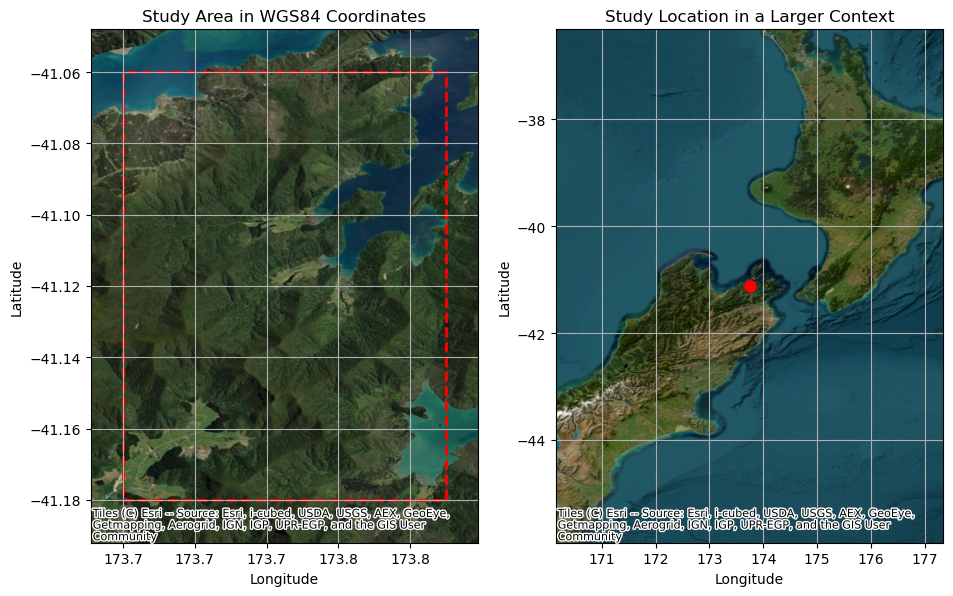

In [4]:
STUDY_SW = (173.7, -41.18)   # Using WGS84, intuitive and easily obtainable from Google Maps, geojson.io etc
STUDY_NE = (173.79, -41.06)
H_BUFFER = 0.1  #Extra space around the study displayed in maps as a fraction of the height
W_BUFFER = 0.1
CONTEXT_SCALE = 40  # Relative size of a second map showing a larger area for context

study_width_deg =  STUDY_NE[0] - STUDY_SW[0]
study_height_deg = STUDY_NE[1] - STUDY_SW[1]

h_buffer_deg = H_BUFFER * study_height_deg
w_buffer_deg = W_BUFFER * study_width_deg

map_sw = (STUDY_SW[0] - w_buffer_deg, STUDY_SW[1] - h_buffer_deg)
map_ne = (STUDY_NE[0] + w_buffer_deg, STUDY_NE[1] + h_buffer_deg)

map_width_deg =  map_ne[0] - map_sw[0]
map_height_deg = map_ne[1] - map_sw[1]

centre_longitude = (map_sw[0] + map_ne[0]) / 2  # Center longitude (average of SW and NE)
centre_latitude = (map_sw[1] + map_ne[1]) / 2   # Center latitude (average of SW and NE)

context_ne = (centre_longitude + study_width_deg * CONTEXT_SCALE,
              centre_latitude + study_height_deg * CONTEXT_SCALE)
context_sw = (centre_longitude - study_width_deg * CONTEXT_SCALE,
              centre_latitude - study_height_deg * CONTEXT_SCALE)

FIGURE_WIDTH = 5
FIGURE_HEIGHT = FIGURE_WIDTH *  map_height_deg / map_width_deg
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*FIGURE_WIDTH + 1, FIGURE_HEIGHT))

rectangle = plt.Rectangle((STUDY_SW),           #(x_min, y_min), width, height
                            study_width_deg, 
                            study_height_deg, 
                            linewidth=2, 
                            edgecolor='red', 
                            facecolor='none',
                            linestyle='--')

ax1.add_patch(rectangle)
ax1.set_xlim(map_sw[0], map_ne[0])
ax1.set_ylim(map_sw[1], map_ne[1])
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.set_title("Study Area in WGS84 Coordinates")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.grid(True)
ctx.add_basemap(ax1, crs="EPSG:4326", source=ctx.providers.Esri.WorldImagery)

ax2.plot(centre_longitude, centre_latitude, 'ro', markersize=8) 
ax2.set_xlim(context_sw[0], context_ne[0])
ax2.set_ylim(context_sw[1], context_ne[1])
ax2.set_title("Study Location in a Larger Context")
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
ax2.grid(True)
ctx.add_basemap(ax2, crs="EPSG:4326", source=ctx.providers.Esri.WorldImagery)

plt.show()

Once we're happy with this, let's reproject those limits to NZTM2000 for the rest of our work.

In [5]:
map_cfg = MapSettings(input_system=4326,
                      map_projection=2193,
                      sw_corner=STUDY_SW,
                      ne_corner=STUDY_NE,
                      buffer=(W_BUFFER, H_BUFFER)
                      )

The original study area was specified in EPSG:4326
The map will be in projected coordinates using EPSG:2193


## Data Extraction
For this I'm going to use LIDAR tiles from LINZ, plus some hydrology layers, just so I cover some common tasks for other projects.  Let's start by getting index tiles and filtering those so we don't download & store more than necessary.

In [6]:
lidar_idx_gdf = gpd.read_file(paths.LIDAR_IDX_GPKG)
lidar_idx_gdf.head(3)

,tilename,geometry
0,BN28_1000_2250,"MULTIPOLYGON (((1683520 5498880, 1684000 54988..."
1,BN28_1000_2349,"MULTIPOLYGON (((1683040 5498160, 1683520 54981..."
2,BN28_1000_2350,"MULTIPOLYGON (((1683520 5498160, 1684000 54981..."


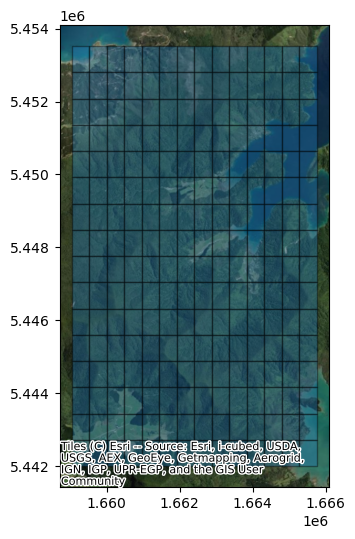

In [7]:
indices_in_map = lidar_idx_gdf[lidar_idx_gdf.intersects(map_cfg.map_polygon)].index
lidar_idx_gdf = lidar_idx_gdf.iloc[indices_in_map]
fig, ax = plt.subplots(figsize=(6, 6))
lidar_idx_gdf.plot(ax=ax, alpha=0.4, edgecolor="black")
ctx.add_basemap(
    ax, 
    source=ctx.providers.Esri.WorldImagery, 
    crs=lidar_idx_gdf.crs.to_string()
)

plt.show()

## Data Exploration

Now let's take a look at the field observations we're provided with

In [8]:
in_df = pd.read_csv(paths.WEKA_POINTS)
geometry = [Point(xy) for xy in zip(in_df['Easting'], in_df['Northing'])]
gdf = gpd.GeoDataFrame(in_df, geometry=geometry)
gdf.set_crs(epsg=map_cfg.EPSG, inplace=True)
input_length = gdf.length
gdf.head()

,Metal band,AgeClass,RDate,Territory,Easting,Northing,Apparent sex,RTime,LocationName,Area,Alive,geometry
0,M-81114,NaN,2011-12-13,NaN,1664541.0,5448992.0,male,NaN,NaN,Duncan Bay non-treatment,True,POINT (1664541 5448992)
1,M-81109,Adult,2010-09-23,Back yard of 207 Duncan Bay Rd,1664026.0,5447704.0,male,15:00:00,NaN,Duncan Bay non-treatment,True,POINT (1664026 5447704)
2,M-81109,Adult,2010-12-01,NaN,1664224.0,5447831.0,male,11:00:00,NaN,Duncan Bay non-treatment,True,POINT (1664224 5447831)
3,M-81109,NaN,2011-11-15,NaN,1664026.0,5447764.0,NaN,8:00:00,Back Yard,Duncan Bay non-treatment,True,POINT (1664026 5447764)
4,M-81110,Adult,2010-09-23,Back yard of 207 Duncan Bay Rd,1664026.0,5447704.0,female,14:10:00,NaN,Duncan Bay non-treatment,True,POINT (1664026 5447704)


In [9]:
indices_in_study = gdf.cx[map_cfg.study_sw[0]:map_cfg.study_ne[0], 
                          map_cfg.study_sw[1]:map_cfg.study_ne[1]].index
gdf['in_study'] = gdf.index.isin(indices_in_study)
gdf['is_empty'] = gdf['geometry'].is_empty
gdf['is_valid'] = gdf.geometry.is_valid
num_out_of_bounds = len(gdf[(gdf['in_study']==False) & (gdf['is_empty']==False)])
print(Colour.S + f"There are {len(gdf[gdf['in_study']==False])} rows with empty or out-of-study geometries" + Colour.E)
print(Colour.S + f"There are {num_out_of_bounds} rows with valid geometries but falling outside the study area" + Colour.E)

There are 277 rows with empty or out-of-study geometries
There are 7 rows with valid geometries but falling outside the study area


So we have a bunch rows with empty points.  Let's plot the rest, and see what's wrong with them.

In [10]:
gdf[(gdf['in_study']==False) & (gdf['is_empty']==False)]

,Metal band,AgeClass,RDate,Territory,Easting,Northing,Apparent sex,RTime,LocationName,Area,Alive,geometry,in_study,is_empty,is_valid
40,M-81116,Adult,2011-10-12,Harvey peninsula,1663729.0,4559218.0,male,10:23:00,NaN,Duncan Bay non-treatment,True,POINT (1663729 4559218),False,False,True
242,V-1201,Adult,2013-10-02,Opuri Saddle,5445522.0,5445522.0,female,12:40:00,NaN,Duncan Bay non-treatment,True,POINT (5445522 5445522),False,False,True
267,M-91311,Adult,2012-09-18,Campground,1662416.0,54447657.0,male,11:40:00,NaN,Duncan Bay non-treatment,True,POINT (1662416 54447657),False,False,True
312,M-91302,Adult,2012-10-04,NaN,1661116.0,1608195.0,male,15:00:00,NaN,Duncan Bay non-treatment,True,POINT (1661116 1608195),False,False,True
591,M-91318,NaN,2014-08-29,NaN,1659857.0,55443126.0,male,NaN,NaN,Duncan Bay non-treatment,True,POINT (1659857 55443126),False,False,True
596,V-0832,NaN,2013-09-03,NaN,16595021.0,5442992.0,female,NaN,NaN,Duncan Bay non-treatment,True,POINT (16595021 5442992),False,False,True
874,M-44455,NaN,2015-02-01,NaN,166187.0,5445507.0,NaN,NaN,NaN,Duncan Bay non-treatment,True,POINT (166187 5445507),False,False,True


Those all look like typos in their coodinates.  I'm going to filter them out for the remainder of this notebook.

In [11]:
gdf = gdf[(gdf['in_study']==True) & (gdf['is_empty']==False)]
gdf.to_file(paths.WEKA_GPKG)
print(Colour.S + f"Total number of recorded Weka sightings with valid locations: " + Colour.E + str(len(gdf)))
print(Colour.S + f"Unique metal band codes (individual birds) in this data: " + Colour.E + str(gdf['Metal band'].nunique()))

Total number of recorded Weka sightings with valid locations: 717
Unique metal band codes (individual birds) in this data: 102


Now let's plot and take a look interactively

In [12]:
gdf_wgs84 = gdf.to_crs(epsg=4326)
study_bounds = [[map_cfg.sw_deg[1],map_cfg.sw_deg[0]], # lat-long format, so [min_y, min_x , max_y, max_x]
                [map_cfg.ne_deg[1],map_cfg.ne_deg[0]]]  
fig_width = 500
fig_height = fig_width * (map_cfg.ne_deg[1]- map_cfg.sw_deg[1]) / (map_cfg.ne_deg[0] - map_cfg.sw_deg[0])

map = Map(center=(0, 0), 
          basemap =ctx.providers.Esri.WorldImagery,         
          layout={'height':f'{fig_height}px', 'width':f'{fig_width}px'},
          scroll_wheel_zoom=True)

standard_colors = [
    '#FF5733',  # Red
    '#33FF57',  # Green
    '#3357FF',  # Blue
    '#FF33A5',  # Pink
    '#000000',  # Black
    '#F3FF33',  # Yellow
    '#FF8C00',  # Dark Orange
    '#6A5ACD',  # Slate Blue
    '#FFD700',  # Gold
    '#FF4500'   # Orange Red
]
unique_bands = gdf['Metal band'].unique()
band_colors = {band: random.choice(standard_colors) for band in unique_bands}
gdf_wgs84['color'] = gdf_wgs84['Metal band'].map(band_colors)

rectangle = Rectangle(
    bounds=study_bounds,  # [[southwest], [northeast]] in lat,long (y,x)
    color='red',
    fill=False,
    stroke=True,
    weight=2
)

map.add(rectangle)

markers = []
for idx, row in gdf_wgs84.iterrows():
    circle_marker = CircleMarker(
        location=(row.geometry.y, row.geometry.x),
        radius=2,
        color=row.color,
        fill_color=row.color,
        fill_opacity=0.8
    )

    map.add(circle_marker)

map.fit_bounds(study_bounds)
map

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

That looks nice.  It's interesting to see how much Weka mix and mingle with each other.  But anyway, now let's do some QGIS processing.

### QGIS Setup

In [13]:
QgsApplication.setPrefixPath(paths.QGIS_PREFIX, True)
from processing.core.Processing import processing

In [14]:
#We can't seem to run this cell more than once without re-starting the kernel first.
#Apparently something isn't getting de-activated fully with qgs.exit()
qgs = QgsApplication([], False)
qgs.initQgis()  
project = QgsProject.instance()
canvas = QgsMapCanvas()
map_crs = QgsCoordinateReferenceSystem(f'EPSG:{map_cfg.EPSG}')
project.read(paths.PROJECT_FILE)  
print(F'The QGIS project file will be located at: {project.fileName()}')

The QGIS project file will be located at: /media/olly/Blue_SSD/Documents/GIS/geoNotebooks/Working/weka_example_project.qgz


In [15]:
gdal_provider = GdalAlgorithmProvider()
QgsApplication.processingRegistry().addProvider(gdal_provider)
QgsApplication.processingRegistry().addProvider(QgsNativeAlgorithms())

True

In [16]:
for idx, alg in enumerate(QgsApplication.processingRegistry().algorithms()):
    print(alg.id())

gdal:aspect
gdal:assignprojection
gdal:buffervectors
gdal:buildvirtualraster
gdal:buildvirtualvector
gdal:cliprasterbyextent
gdal:cliprasterbymasklayer
gdal:clipvectorbyextent
gdal:clipvectorbypolygon
gdal:colorrelief
gdal:contour
gdal:contour_polygon
gdal:convertformat
gdal:dissolve
gdal:executesql
gdal:extractprojection
gdal:fillnodata
gdal:gdal2tiles
gdal:gdal2xyz
gdal:gdalinfo
gdal:gridaverage
gdal:griddatametrics
gdal:gridinversedistance
gdal:gridinversedistancenearestneighbor
gdal:gridlinear
gdal:gridnearestneighbor
gdal:hillshade
gdal:importvectorintopostgisdatabaseavailableconnections
gdal:importvectorintopostgisdatabasenewconnection
gdal:merge
gdal:nearblack
gdal:offsetcurve
gdal:ogrinfo
gdal:onesidebuffer
gdal:overviews
gdal:pansharp
gdal:pcttorgb
gdal:pointsalonglines
gdal:polygonize
gdal:proximity
gdal:rastercalculator
gdal:rasterize
gdal:rasterize_over
gdal:rasterize_over_fixed_value
gdal:rearrange_bands
gdal:retile
gdal:rgbtopct
gdal:roughness
gdal:sieve
gdal:slope
gdal:t

In [17]:
weka_pts_lyr = QgsVectorLayer(paths.WEKA_GPKG, "Weka Points", "ogr")

if weka_pts_lyr.isValid():
    project.addMapLayer(weka_pts_lyr)
    canvas.setExtent(weka_pts_lyr.extent())
    canvas.setLayers([weka_pts_lyr])
    #canvas.show()   
    print('Weka points added to the project')
else:
    print("Layer failed to load!")
project.write(paths.PROJECT_FILE)

Weka points added to the project


True

In [18]:
class MakeLayout:
    '''A class to handle presentation of layers into displayable and saveable images'''
    def __init__(self,
                 temp_image_path,
                 paper_size='a5', #options: 'a3', 'a4, 'a5'
                 landscape=True,
                 width=None,
                 height=None,
                 ):
        _paper_sizes = {'a3':(297, 420),
                        'a4':(210, 297),
                        'a5':(148, 210)}
        _width_idx = 1 if landscape else 0
        _height_idx = 0 if landscape else 1

        self.width = _paper_sizes[paper_size][_width_idx] if width is None else width
        self.height = _paper_sizes[paper_size][_height_idx] if height is None else width
        self.tmp_img_pth = temp_image_path


    def show_working(self, project):
        if Path(self.tmp_img_pth).exists():
            Path(self.tmp_img_pth).unlink()
        layout = QgsPrintLayout(project)
        layout.initializeDefaults()
        layout.pageCollection().pages()[0].setPageSize(QgsLayoutSize(self.width, self.height, QgsUnitTypes.LayoutMillimeters))  #Sets the page size, in mm    
        #a4 = A4 Portrait (210 × 297 mm),  a5 landscape (210 x 148)

        # Compute the combined extent of all layers in the project
        extent = None
        for layer in project.mapLayers().values():
            print(layer, layer.extent())
            if layer.type() in {QgsMapLayer.VectorLayer, QgsMapLayer.RasterLayer}:
                layer_extent = layer.extent()
                if extent is None:
                    extent = QgsRectangle(layer_extent)
                else:
                    extent.combineExtentWith(layer_extent)

        print(f'The combined extent is {extent}')

        if extent is None:
            print("No visible layers found.")
            return

        map_rect = QRectF(10, 10, 200, 400)  # (x,y, width, height)  (x,y) is top left corner. Units in mm, (map layout)

        # Create a thin grey border **BEHIND** the map
        border = QgsLayoutItemShape(layout)
        border.setShapeType(QgsLayoutItemShape.Rectangle)
        border.setRect(map_rect)  # Match map item size
        #border.setStrokeColor(QColor(150, 150, 150))  # Grey color
        #border.setStrokeWidth(0.5)  # Thin line
        border.setReferencePoint(QgsLayoutItem.UpperLeft)
        layout.addLayoutItem(border)  # Add border **first**, so it's behind

        # Create the map item and set it **after** the border
        map_item = QgsLayoutItemMap(layout)
        map_item.setRect(map_rect)  # Match border size
        map_item.setExtent(extent)
        layout.addLayoutItem(map_item)  # Map item is **added last**, so it's on top

        #exporter = QgsLayoutExporter(layout)
        #exporter.exportToImage(temp_img_path, QgsLayoutExporter.ImageExportSettings())

        exporter = QgsLayoutExporter(layout)
        settings = QgsLayoutExporter.ImageExportSettings()
        settings.dpi = 300  # Sets the total pixels of the output
        exporter.exportToImage(self.tmp_img_pth, settings)

        # Display the exported image with IPython Image
        # With here refers to the display width in the notebook.  Has no effect on the image file its self.
        display(IPImage(self.tmp_img_pth, width=600))  

In [19]:
a5_lscape_layout = MakeLayout(temp_image_path=paths.CANVAS_IMG,
                              paper_size='a5',
                              landscape=False)

<QgsVectorLayer: 'Weka Points' (ogr)> <QgsRectangle: 1659251 5442928, 1665319 5453997>
The combined extent is <QgsRectangle: 1659251 5442928, 1665319 5453997>


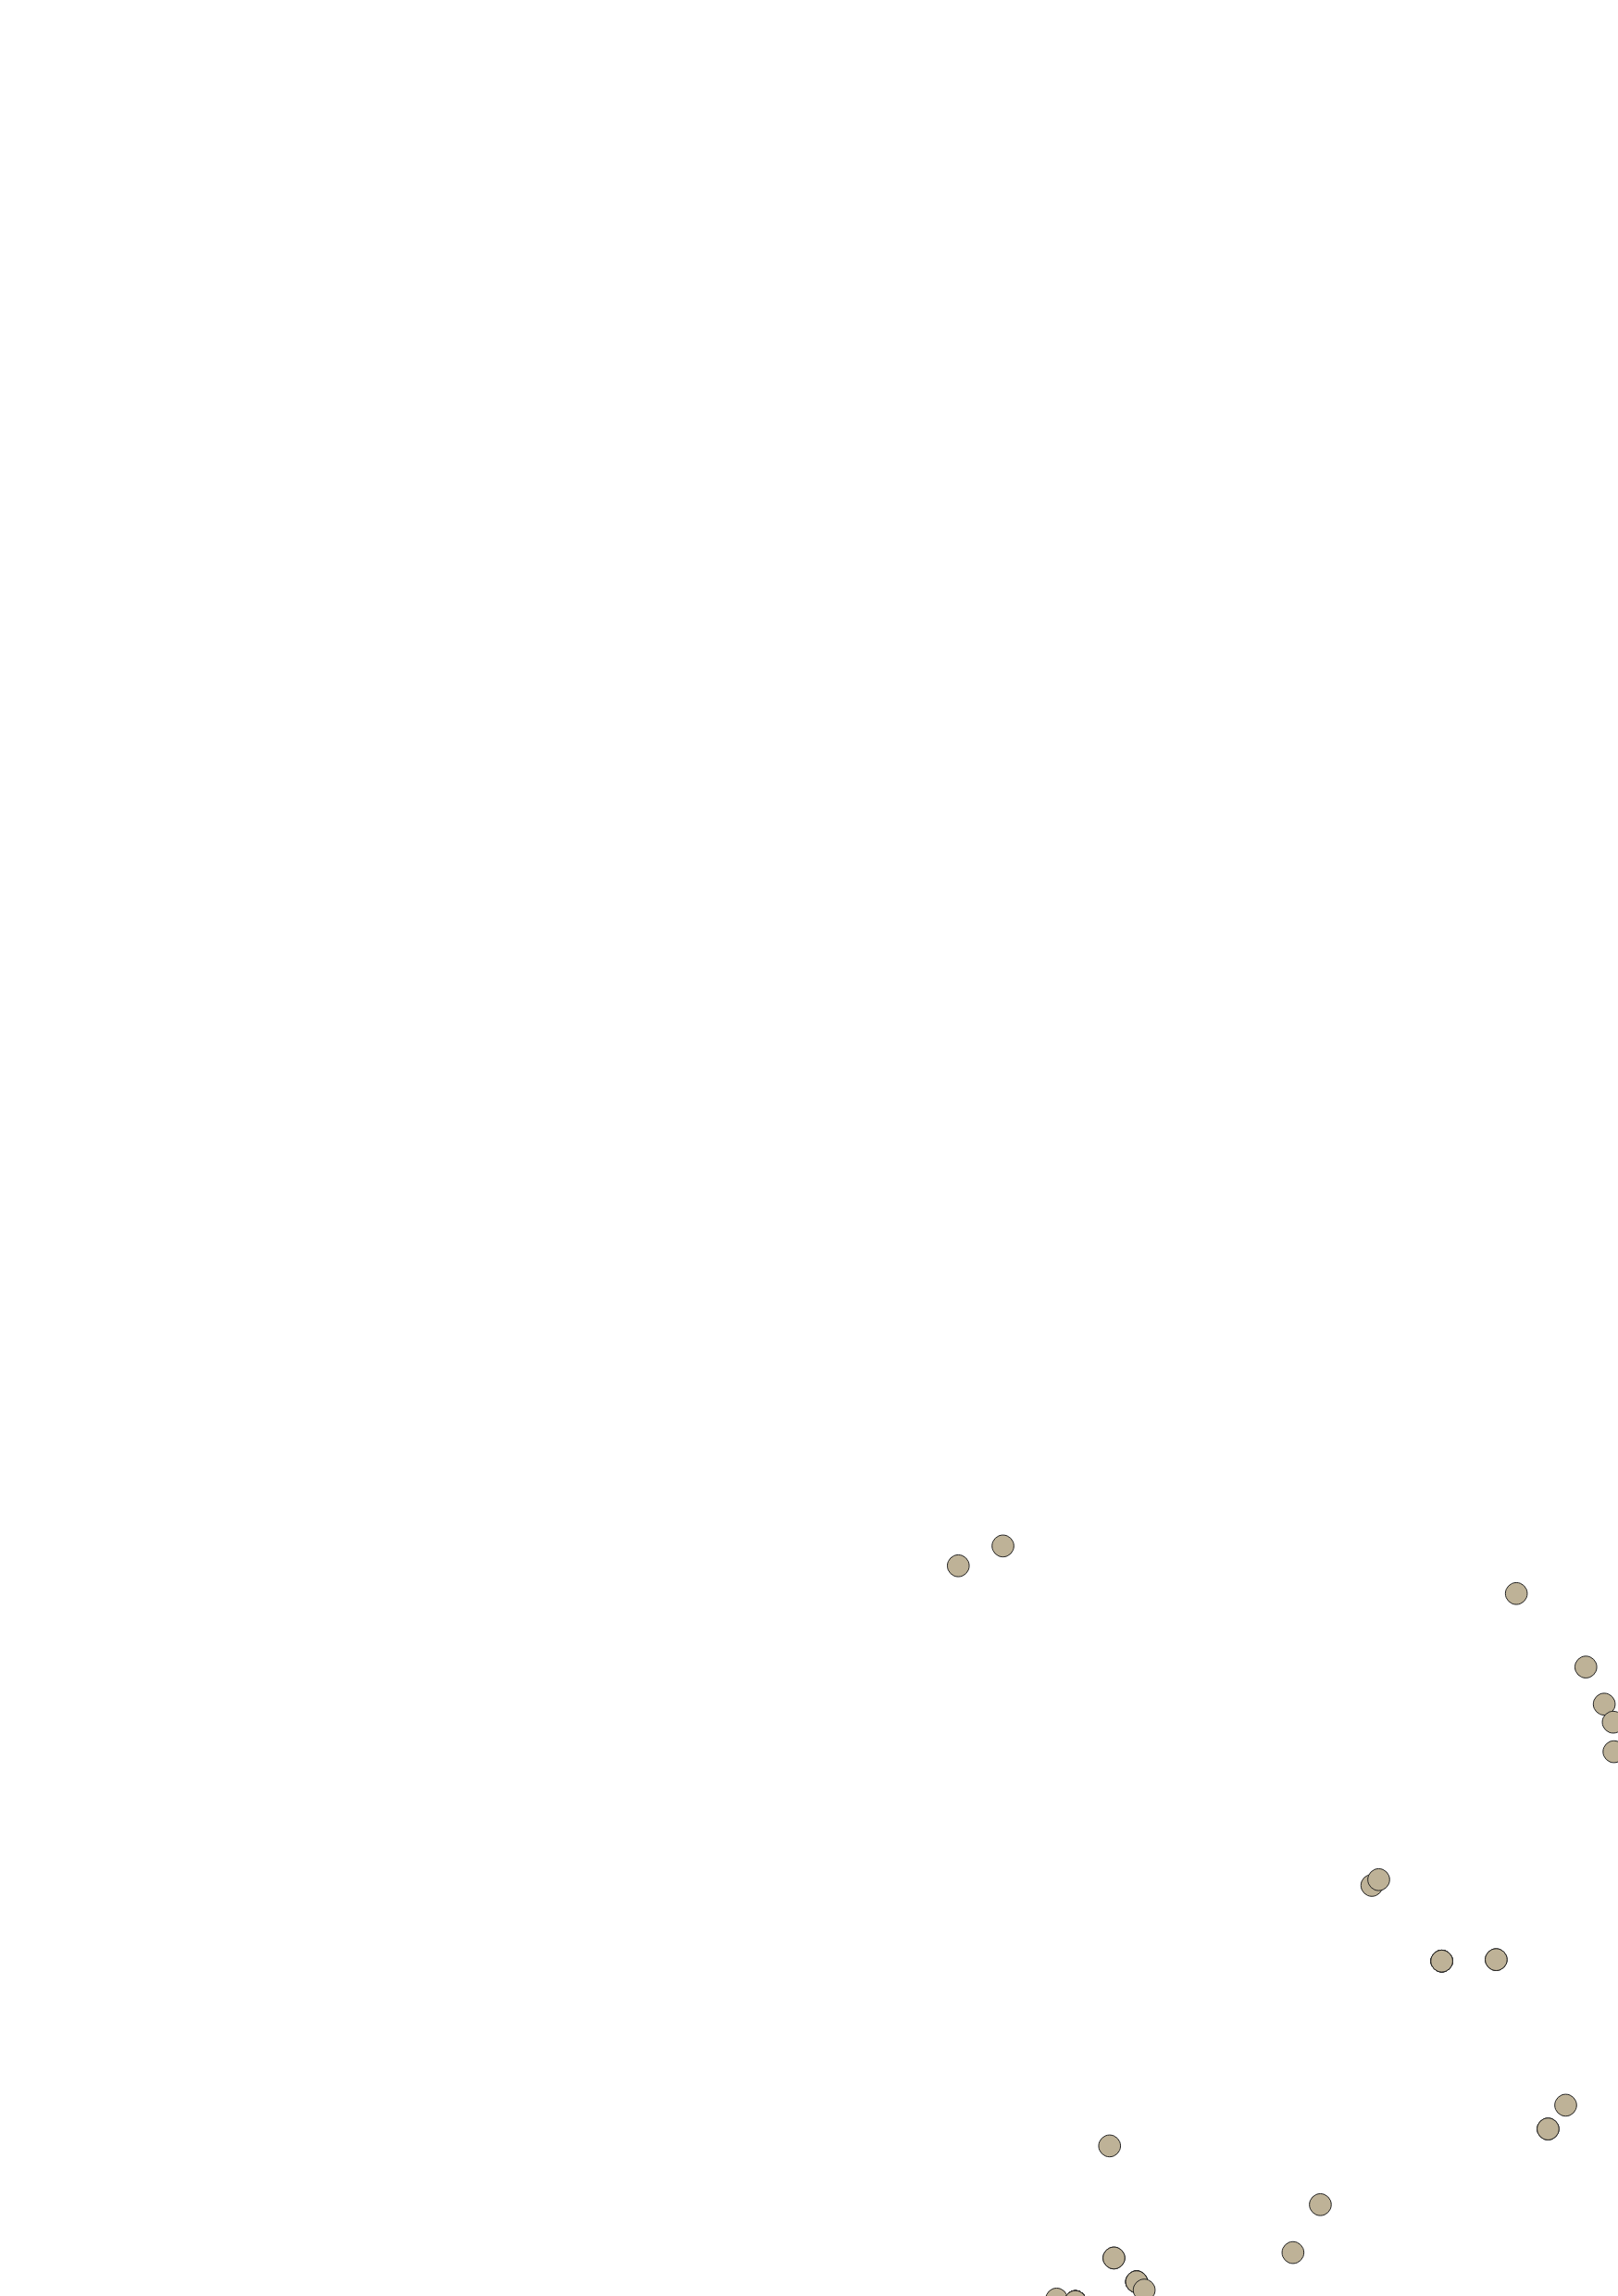

In [20]:
a5_lscape_layout.show_working(project)

Let's add the LIDAR tiles to make a nice hillshade basemap.  The resampling can be done most efficiently with GDAL.

In [21]:
lidar_idx_gdf["tile_prefix"] = paths.LIDAR_TILES + '/DEM_' + lidar_idx_gdf["tilename"].str[:5] + '2020_'
lidar_idx_gdf["tile_suffix"] = lidar_idx_gdf["tilename"].str[5:] + '.tif'
lidar_idx_gdf['filepath'] = lidar_idx_gdf["tile_prefix"] + lidar_idx_gdf["tile_suffix"]
lidar_idx_gdf.drop(columns=['tile_prefix', 'tile_suffix'], inplace=True)
pd.set_option('display.max_colwidth', None)
lidar_idx_gdf.head(3)

,tilename,geometry,filepath
745,BP27_1000_3549,"MULTIPOLYGON (((1659040 5453520, 1659520 5453520, 1659520 5452800, 1659040 5452800, 1659040 5453520)))",/media/olly/Blue_SSD/Documents/GIS/geoNotebooks/Data/lds-marlborough-lidar-1m-dem-2020-2022-GTiff/DEM_BP27_2020_1000_3549.tif
746,BP27_1000_3550,"MULTIPOLYGON (((1659520 5453520, 1660000 5453520, 1660000 5452800, 1659520 5452800, 1659520 5453520)))",/media/olly/Blue_SSD/Documents/GIS/geoNotebooks/Data/lds-marlborough-lidar-1m-dem-2020-2022-GTiff/DEM_BP27_2020_1000_3550.tif
765,BP27_1000_3649,"MULTIPOLYGON (((1659040 5452800, 1659520 5452800, 1659520 5452080, 1659040 5452080, 1659040 5452800)))",/media/olly/Blue_SSD/Documents/GIS/geoNotebooks/Data/lds-marlborough-lidar-1m-dem-2020-2022-GTiff/DEM_BP27_2020_1000_3649.tif


In [22]:
target_resolution = 4.0
in_memory_rasters = []

# Resample each tile and keep in memory
for path in lidar_idx_gdf['filepath'].to_list():
    raster_dataset = gdal.Open(path)
    if not raster_dataset:
        print(f"Failed to load layer: {path}")
        continue

    resampled = gdal.Warp(
        '',  # Output to in-memory
        raster_dataset,
        xRes=target_resolution,
        yRes=target_resolution,
        resampleAlg='bilinear',
        format='MEM'  # Use MEM to keep in memory
    )
    
    in_memory_rasters.append(resampled)

# Merge the resampled in-memory rasters into a single VRT
vrt_options = gdal.BuildVRTOptions(resampleAlg='bilinear')
vrt_dataset = gdal.BuildVRT('/vsimem/merged.vrt', in_memory_rasters, options=vrt_options)

gdal.Translate(paths.LIDAR_GEOTIFF, vrt_dataset, format='GTiff')
print(f"Merged & resampled raster saved to {paths.LIDAR_GEOTIFF}")

Merged & resampled raster saved to /media/olly/Blue_SSD/Documents/GIS/geoNotebooks/Data/map_area_lidar_dem.tif


In [23]:
merged_layer = QgsRasterLayer(paths.LIDAR_GEOTIFF, "LiDAR DEM")

if not merged_layer.isValid():
    print("Failed to load merged raster layer.")
else:
    QgsProject.instance().addMapLayer(merged_layer)
    print("Merged raster layer loaded successfully.")

Merged raster layer loaded successfully.


In [24]:
def make_hillshade(raster, path):
    layers = QgsProject.instance().mapLayers() #returns a dict, values = layer object
    hs_name = 'hs_' + raster.name() + '.tif'
    
    for layer in layers.values():
        if layer.name() == hs_name:
            QgsProject.instance().removeMapLayer(layer)
    
    hs_pth = str(path / hs_name)
    hs_param = {'INPUT': raster.name(), 
      'BAND': 1, 
      'COMPUTE_EDGES': False,
      'ZEVENBERGEN': False,
      'Z_FACTOR': 1.0,
      'SCALE': 1,  #111120, # should automate this setting to match the coordinate system
      'AZIMUTH': 315,
      'COMBINED': False,
      'ALTITUDE': 45,
      'MULTIDIRECTIONAL': False,
      'OUTPUT': hs_pth}
    processing.run('gdal:hillshade',hs_param)
    
    root = QgsProject.instance().layerTreeRoot()
    group = root.findGroup(raster.name())
    hs_lyr = QgsRasterLayer(hs_pth, hs_name, "gdal")
    QgsProject.instance().addMapLayer(hs_lyr, False)
    if group: 
        group.insertChildNode(0, QgsLayerTreeLayer(hs_lyr))
    else:
        root.insertChildNode(0, QgsLayerTreeLayer(hs_lyr))
    return QgsProject.instance().mapLayersByName(hs_name)[0]


def make_symbology(raster):
    stats = raster.dataProvider().bandStatistics(1)
    min = stats.minimumValue
    max = stats.maximumValue
    colours = ['#005B00', '#1A6E1A','#5C8E4A','#839B60','#AAA776','#D2B48C','#C0C0C0'] # Low to high
    interval = (max-min)/(len(colours)-1)
    values = [min+interval*i for i in range(len(colours)-1)] + [max]
    rmp_lst=[]
    for value, colour in zip(values,colours):
        rmp_lst.append(QgsColorRampShader.ColorRampItem(value, QColor(colour)))
    
    fnc = QgsColorRampShader()  #Create a ramp shader
    fnc.setColorRampType(QgsColorRampShader.Interpolated)   # sets the ramp type to Interpolated
    fnc.setColorRampItemList(rmp_lst)  # puts the list into the QgsColorRampShader
    shader = QgsRasterShader()  #names a variable for the QgsRasterShader
    shader.setRasterShaderFunction(fnc)  # passes the RampShader into the RasterShader
    renderer = QgsSingleBandPseudoColorRenderer(raster.dataProvider(), 1, shader) #Pass the shader into the renderer
    raster.setRenderer(renderer) #Apply the renderer to the raster
    raster.renderer().setOpacity(0.6)
    raster.setBlendMode(QPainter.CompositionMode_Multiply)


def reorder_lyrs(rstr_lyr,hs_lyr):
    root = QgsProject.instance().layerTreeRoot()
    rstr_node = root.findLayer(rstr_lyr)  # Finds the node belonging to the DEM
    hs_node = root.findLayer(hs_lyr)  # Finds the node of the hillshade.
    parent_node = rstr_node.parent()
    if parent_node == root:
        group_idx = root.findLayers().index(rstr_node) # doesn't count empty groups
        group = root.insertGroup(group_idx, rstr_lyr.name())
        for lyr_node in [rstr_node, hs_node]:
            cloned = lyr_node.clone()
            group.addChildNode(cloned)
            root.removeChildNode(lyr_node)
    else: #Shouldn't be needed If I'm sure the hillshade is inserted below the DEM layer
        rstr_idx = parent_node.findLayers().index(rstr_node)  # The index of the DEM node
        cloned = hs_node.clone()
        parent_node.insertChildNode(rstr_idx+1, cloned)
        parent_node.removeChildNode(hs_node)
        group = parent_node
    return group


def make_terrain(rstr_lyr, prjpath):
    rslts_pth = prjpath / 'Results'
    hs_lyr = make_hillshade(rstr_lyr, rslts_pth)
    make_symbology(rstr_lyr)
    group = reorder_lyrs(rstr_lyr, hs_lyr)
    return group

new_lyrs = make_terrain(merged_layer, paths.DATA)

<QgsRasterLayer: 'LiDAR DEM' (gdal)> <QgsRectangle: 1659040 5442000, 1665760 5453520>
<QgsVectorLayer: 'Weka Points' (ogr)> <QgsRectangle: 1659251 5442928, 1665319 5453997>
<QgsRasterLayer: 'hs_LiDAR DEM.tif' (gdal)> <QgsRectangle()>
The combined extent is <QgsRectangle: 1659040 5442000, 1665760 5453997>


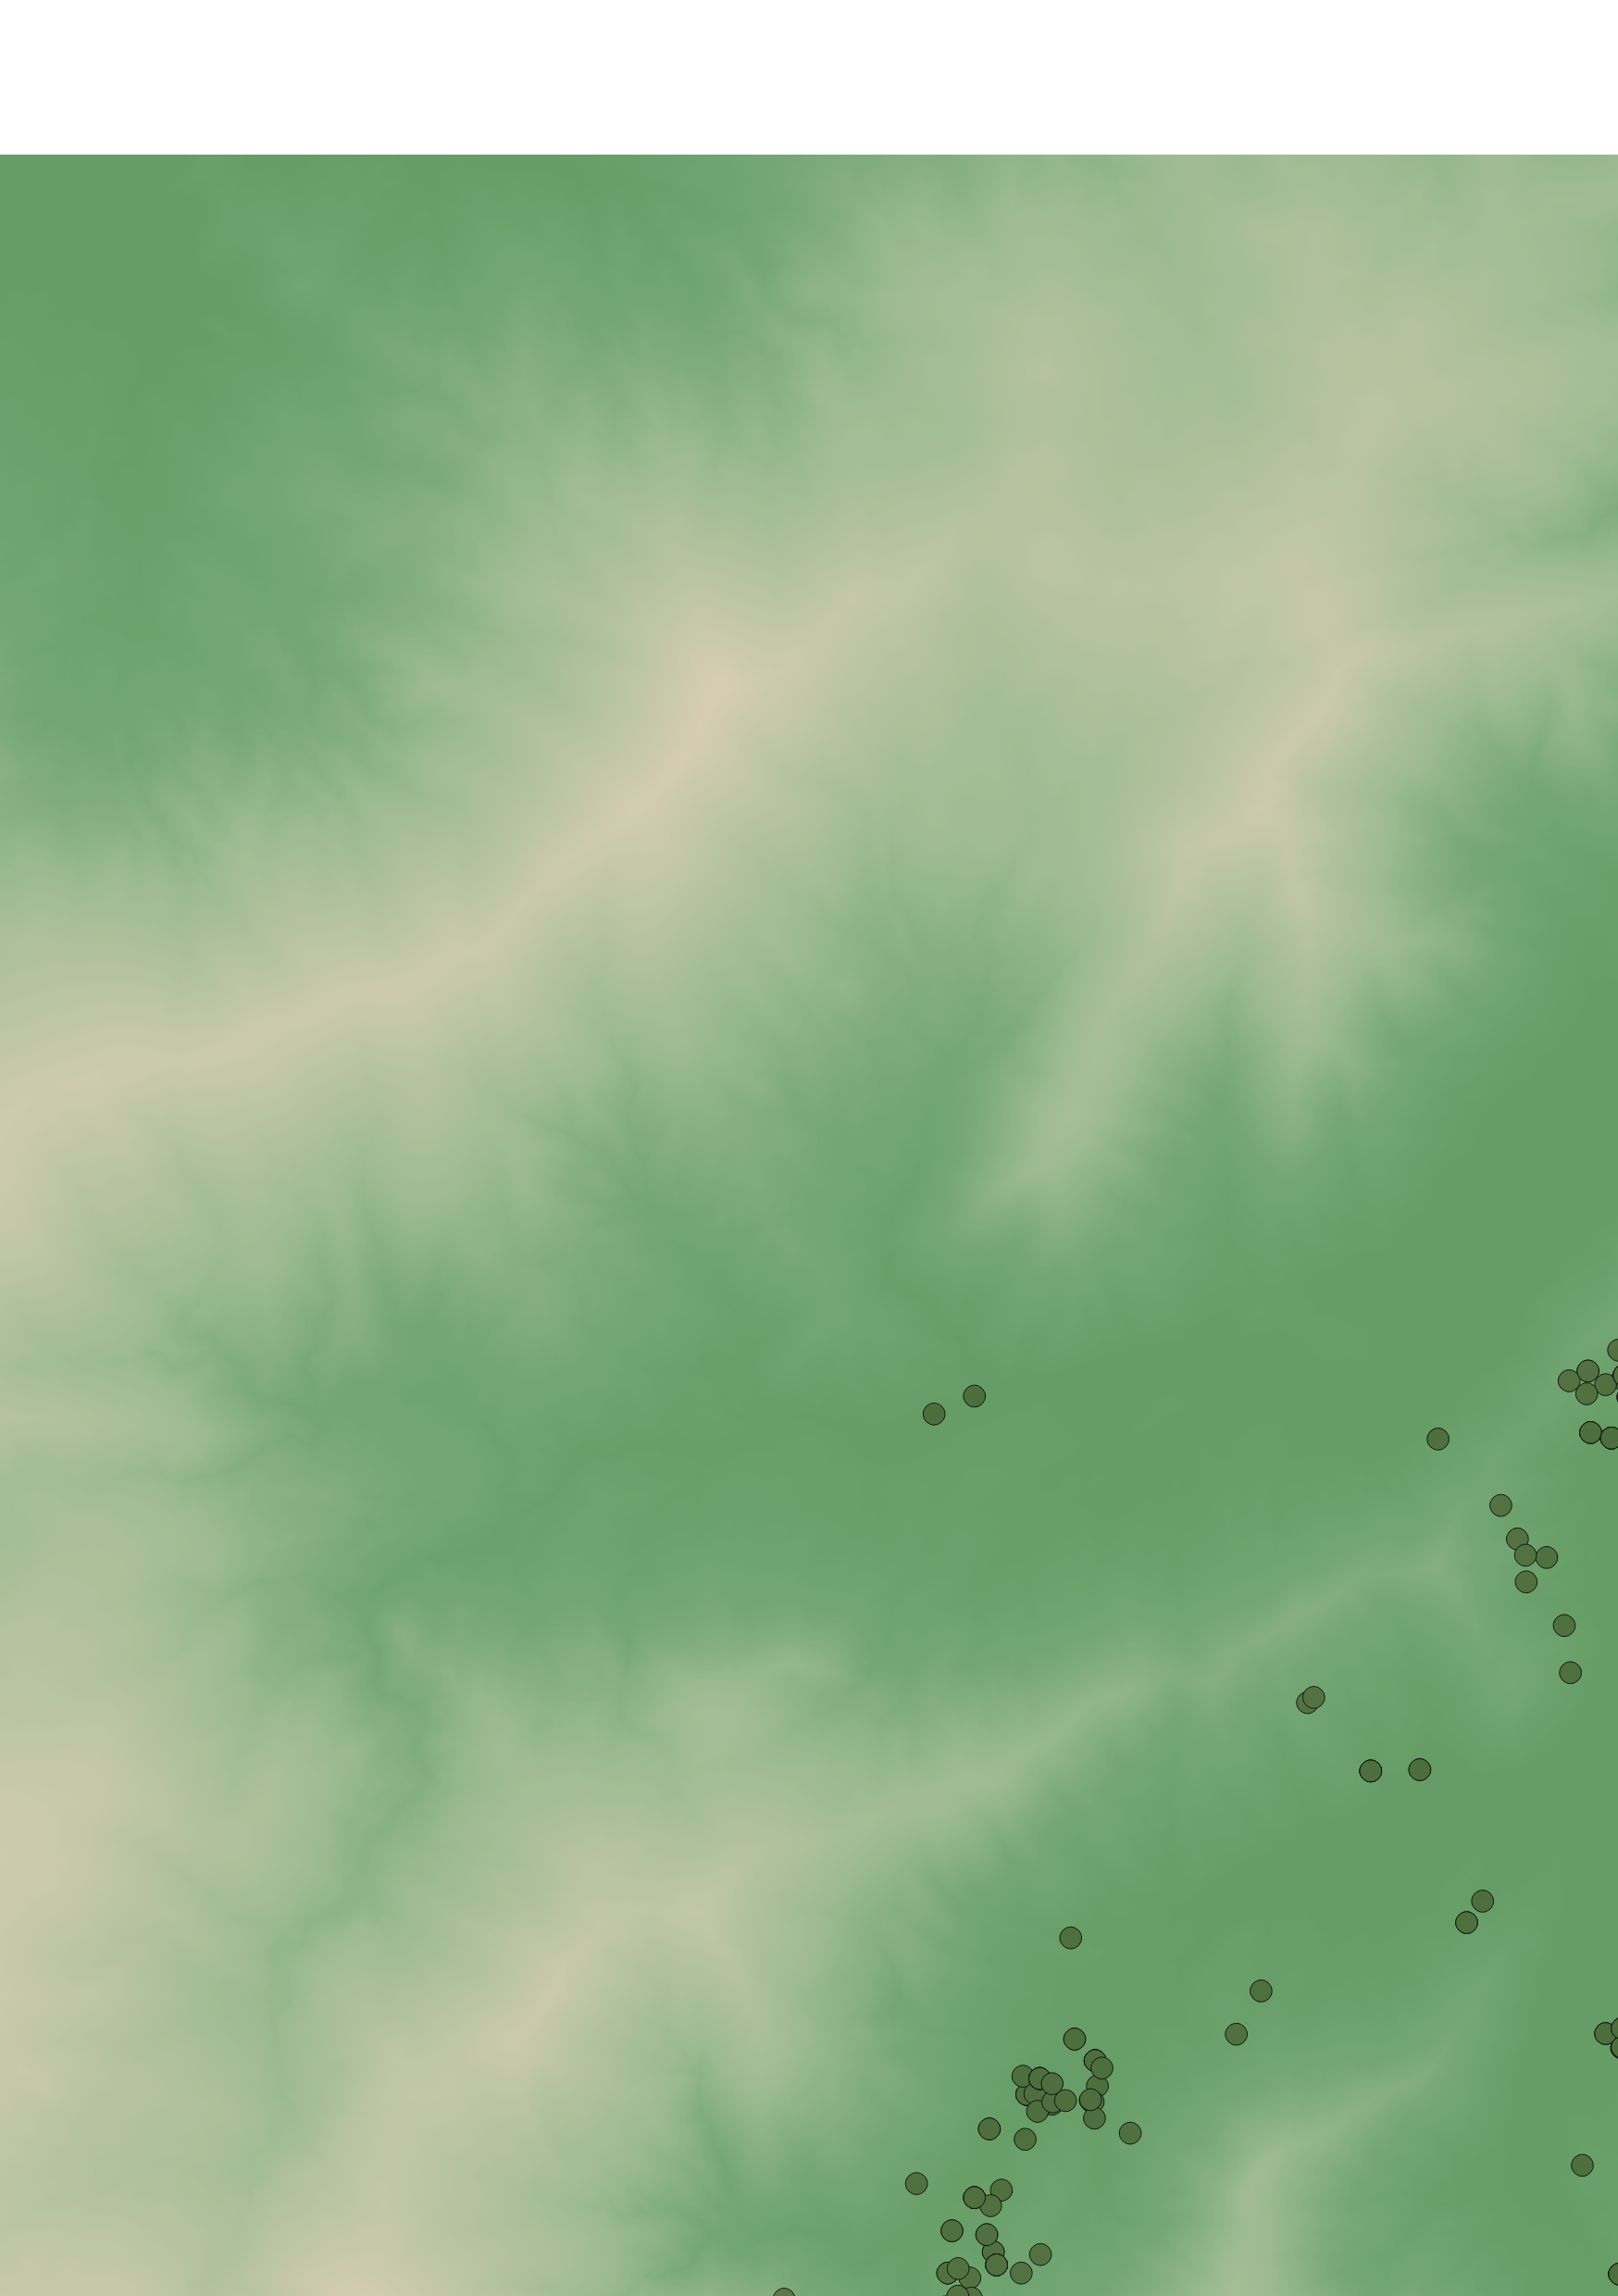

In [25]:
a5_lscape_layout.show_working(project)

In [26]:
qgs.exit()

In [27]:
print('\033[1m' + '\033[94m' + "God damn it Gump you're goddamn genius. \n"
      "That's the most outstanding answer I've ever heard.\n"
      "You must have a goddam IQ of 160.\n"
      "You are goddam gifted private Gump." + '\033[0m')

God damn it Gump you're goddamn genius. 
That's the most outstanding answer I've ever heard.
You must have a goddam IQ of 160.
You are goddam gifted private Gump.
